In [ ]:
import numpy as np
from scipy import signal
import plotly.graph_objects as go
from database_tools.preprocessing.functions import bandpass

In [ ]:
x = 1
y1 = 'PPG0'
y2 = 'PPG1'

with open(f'data/TX{x}DATA{y1}.txt', 'r') as f:
    ppg_i_data = [l.strip('\n') for l in f.readlines()]

with open(f'data/TX{x}DATA{y2}.txt', 'r') as f:
    ppg_r_data = [l.strip('\n') for l in f.readlines()]

ppg_i = np.array(ppg_i_data[4::]).astype(int)
ppg_i_flip = np.max(ppg_i) - ppg_i
ppg_i_filt = bandpass(ppg_i_flip, low=0.5, high=8.0, fs=200)

ppg_r = np.array(ppg_r_data[4::]).astype(int)
ppg_r_flip = np.max(ppg_r) - ppg_r
ppg_r_filt = bandpass(ppg_r_flip, low=0.5, high=8.0, fs=200)

In [ ]:
fig = go.Figure()

# fig.add_scatter(y=ppg_i_flip, name='IR Flipped')
fig.add_scatter(y=ppg_i_filt, name='IR Filtered')

# fig.add_scatter(y=ppg_r_flip, name='Red Flipped')
fig.add_scatter(y=ppg_r_filt, name='Red Filtered')

combined = (ppg_i_filt + ppg_r_filt) / 2
fig.add_scatter(y=combined, name='combined')

In [ ]:
import os
import time
import numpy as np
import plotly.graph_objects as go
from database_tools.preprocessing.spo2 import calc_spo2, find_peaks
from database_tools.preprocessing.functions import bandpass

i = 34
ppg0 = f'data/TX{i}DATAPPG0.txt'
ppg1 = f'data/TX{i}DATAPPG1.txt'
while True:
    if os.path.exists(ppg1):
        with open(f'data/TX{i}DATAPPG0.txt', 'r') as f:
            ppg_i_data = [l.strip('\n') for l in f.readlines()]
        with open(f'data/TX{i}DATAPPG1.txt', 'r') as f:
            ppg_r_data = [l.strip('\n') for l in f.readlines()]
        i += 1
        ppg0 = f'data/TX{i}DATAPPG0.txt'
        ppg1 = f'data/TX{i}DATAPPG1.txt'

        ppg_i = np.array(ppg_i_data[4::]).astype(int)
        ppg_r = np.array(ppg_r_data[4::]).astype(int)

        fig = go.Figure()
        fig.add_scatter(y=ppg_i, name='IR Filtered')
        fig.add_scatter(y=ppg_r, name='Red Filtered')
        fig.show()

        results = {'spo2': [], 'r': []}
        for j in range(4):
            idx = (j*1025, (j+1)*1025)
            spo2, r = calc_spo2(ppg_r[idx[0]:idx[1]], ppg_i[idx[0]:idx[1]], return_peaks=False)
            results['spo2'].append(spo2)
            results['r'].append(r)

        ppg_i_flip = np.max(ppg_i) - ppg_i
        ppg_i_filt = bandpass(ppg_i_flip, low=0.5, high=8.0, fs=200)

        ppg_r_flip = np.max(ppg_r) - ppg_r
        ppg_r_filt = bandpass(ppg_r_flip, low=0.5, high=8.0, fs=200)
        combined = (ppg_i_filt + ppg_r_filt) / 2

        peaks = find_peaks(combined)
        heart_rate = int(round(len(peaks['peaks']) * 2.926829268292683, 0))
        print(results, heart_rate)
    else:
        time.sleep(5)

In [ ]:
fig = go.Figure()

ir_peaks = peaks['ir_peaks']
ir_troughs = peaks['ir_troughs']

fig.add_scatter(y=ppg_i[i[0]:i[1]])
fig.add_scatter(x=ir_peaks, y=ppg_i[i[0]:i[1]][ir_peaks], mode='markers')
fig.add_scatter(x=ir_troughs, y=ppg_i[i[0]:i[1]][ir_troughs], mode='markers')

In [29]:
import pickle as pkl
from scipy import signal
from database_tools.preprocessing.utils import window

x = 41

with open(f'data/TX{x}DATAPPG0.txt', 'r') as f:
    ppg_i_data = [l.strip('\n') for l in f.readlines()]

with open(f'data/TX{x}DATAPPG1.txt', 'r') as f:
    ppg_r_data = [l.strip('\n') for l in f.readlines()]

ppg_i = np.array(ppg_i_data[4::]).astype(int)
ppg_i_flip = np.max(ppg_i) - ppg_i
ppg_i_filt = bandpass(ppg_i_flip, low=0.5, high=8.0, fs=200)

ppg_r = np.array(ppg_r_data[4::]).astype(int)
ppg_r_flip = np.max(ppg_r) - ppg_r
ppg_r_filt = bandpass(ppg_r_flip, low=0.5, high=8.0, fs=200)

combined = (ppg_i_filt + ppg_r_filt) / 2

fig = go.Figure()

fig.add_scatter(y=ppg_i_filt, name='IR Filtered')
fig.add_scatter(y=ppg_r_filt, name='Red Filtered')
fig.add_scatter(y=combined, name='combined')
fig.show()

print(np.min(combined), np.max(combined))
combined = np.divide(combined - np.min(combined), np.max(combined) - np.min(combined))
combined = signal.resample(combined, 2562)

idx = window(combined, win_len=256, overlap=0)

-374.05160126137844 548.380603132149


In [31]:
idx_0 = idx[1]

ppg = combined[idx_0[0]:idx_0[1]].reshape(1, -1)
vpg = np.gradient(ppg, axis=1)  # 1st derivative of ppg
apg = np.gradient(vpg, axis=1) # 2nd derivative of vpg

with open('test-data.pkl', 'wb') as f:
    pkl.dump((ppg, vpg, apg), f)

<AxesSubplot: >

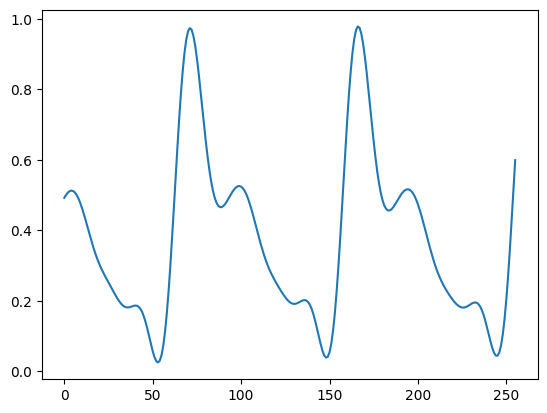

In [32]:
import pandas as pd

pd.Series(ppg.reshape(-1)).plot()